# [download do dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download)

<br>
Google Colab não permite fazer upload direto da pasta

* zip a pasta e depois execute !unzip







In [ ]:
!unzip data.zip


# bibliotecas

In [ ]:
import torch
from torch import nn , optim
from torchvision import datasets , transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##transforms.Compose()
+ agrupamento de varias transformações <br>
resize() > redimensiona a img <br>
ToTensor() > converte a img para tensor <br>
normalize () > normaliza os dados de entrada


---


+ train_dl / test_dl
batch_size=32 > agrupa 1 lote com 32 imgs <br>

datasets.ImageFolder(/content/data/Training,tf) > pega as imgs da pasta e aplica as configs de tf <br>

num_workers > acelera o carregamento <br>

pin_memory=True > otimiza a performace , transformando a transferência de dados da CPU para GPU mais rápida <br>

shuffle = true > embaralha os dados


In [ ]:
tf = transforms.Compose([
    transforms.Resize((128,128)),# Redimensiona a imagem para  128x128 pixels
    transforms.ToTensor(), #Converte a imagem para um Tensor do PyTorch
    transforms.Normalize([0.5 ,0.5 ,0.5],[0.5 ,0.5 ,0.5]) #cores (cinza)
    ])

train_dl = DataLoader(
    datasets.ImageFolder('/content/data/Training',tf),
    batch_size=32,shuffle=True , num_workers = 4, pin_memory=True)


test_dl = DataLoader(datasets.ImageFolder('/content/data/Testing',tf),
                     batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Rede Neural Convolucional <br>
+ A rede ira receber uma img colorida
+ ela começa a aprender com 32 kernels(caracteristicas) e termina com 128
+ ReLu () > função de ativação não linear
+ MaxPool2d () > reduz a img pela metade , para manter as caracteristicas mais importantes
+ Flatten() > os dados estão em formato 3d (altura , largura e canais )o flatten vai achatar esses dados em um unico vetor , é preciso fazer isso para conectar a parte convolucional com a fully connected

+ to(device) > manda para a GPU

+ nn.Linear(128 *16 *16, 256) , nn.ReLU() , nn.Dropout(0.5) > Uma camada densa , onde o vetor achatado (tamanho do mapa de caracteristicas apos 3 camadas de maxpool) transformando um vetor de 256 caracteristicas

<br>



* Dropout > desliga 50% dos neurônios durante o treino , para previnir overfitting

* nn.Linear(256,4) > Ela pega as 256 características da camada anterior e as transforma em 4 valores (logits), um para cada classe que o modelo deve prever.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), nn.ReLU() , nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU() , nn.MaxPool2d(2),
    nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU() , nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(128 *16 *16, 256) , nn.ReLU() , nn.Dropout(0.5),
    nn.Linear(256,4)
).to(device)


Otimizador (AdamW) para ajustar todos os parâmetros do seu model com passos de tamanho 0.0001.

* 1e-4: Esta é a taxa de aprendizado (learning rate)
 , Ela controla o tamanho do "passo" que o otimizador dá ao ajustar os pesos

* model.parameters() > fornece uma  lista de todos os parametros (pesos e bias ) do ***model*** e atualiza os parametros

In [ ]:
opt = optim.AdamW(model.parameters() , 1e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
print(device)

cuda


In [ ]:
model.train()

for epoch in range(25):

  running_loss = 0

  for x,y in train_dl:
    opt.zero_grad()

    loss = loss_fn(model(x.to(device)), y.to(device))
    loss.backward()

    running_loss +=loss
    opt.step()

  print(f"epoch {epoch+1}: loss was {running_loss:.2f}")



epoch 1: loss was 149.53
epoch 2: loss was 101.69
epoch 3: loss was 84.13
epoch 4: loss was 74.48
epoch 5: loss was 66.00
epoch 6: loss was 59.30
epoch 7: loss was 52.46
epoch 8: loss was 48.48
epoch 9: loss was 42.96
epoch 10: loss was 38.56
epoch 11: loss was 34.91
epoch 12: loss was 31.99
epoch 13: loss was 27.46
epoch 14: loss was 24.24
epoch 15: loss was 23.18
epoch 16: loss was 20.07
epoch 17: loss was 18.87
epoch 18: loss was 16.84
epoch 19: loss was 15.47
epoch 20: loss was 13.60
epoch 21: loss was 13.09
epoch 22: loss was 11.63
epoch 23: loss was 10.07
epoch 24: loss was 11.27
epoch 25: loss was 8.62


In [ ]:
model.eval()
test_loss , correct = 0.0 , 0

with torch.no_grad():
  for x,y in test_dl:
    x,y = x.to(device), y.to(device)

    logits = model(x)
    test_loss += loss_fn(logits, y).item() * y.size(0)

    preds = logits.argmax(dim=1)
    correct += (preds == y).sum().item()

test_loss /= len(test_dl.dataset)
accuracy = 100.0 * correct / len(test_dl.dataset)

print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


Test Loss: 0.1267, Accuracy: 96.03%


In [ ]:
perda = test_loss/ len(test_dl.dataset)
print(perda)

9.665965643536418e-05


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

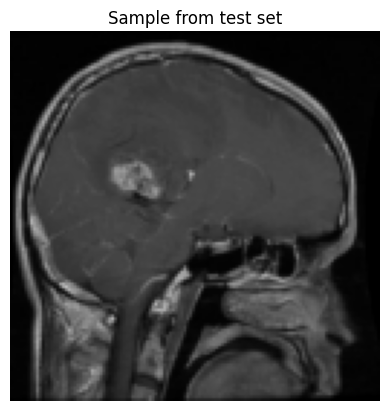

A classe sorteada é : glioma
O modelo prevê: glioma


In [ ]:
import random

import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model.eval()

idx = random.randrange(len(test_dl.dataset))
img , label = test_dl.dataset[idx]

unnorm = img * 0.5 + 0.5

plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title('Sample from test set')
plt.show()

with torch.no_grad():
  logits = model(img.unsqueeze(0).to(device))
  pred = logits.argmax(dim=1).item()

class_names = test_dl.dataset.classes

print(f"A classe sorteada é : {class_names[pred]}")
print(f"O modelo prevê: {class_names[label]}")


In [ ]:
torch.save(model.state_dict(), "modelo_brain-tumor.pth")